# Simple analytics on collected logging

In [27]:
paths = [
  '46-101-119-181-20200329-ping.log',
  '46-101-119-181-20200330-ping.log',
  '46-101-119-181-20200331-ping.log',  
  '46-101-119-181-20200401-ping.log',
  '46-101-119-181-20200402-ping.log'
  ]
ip = paths[0].split('-').slice(0, 4).inject{ |n, e| "#{n}.#{e}" } # get IP from file name
requests = []

paths.each do |path|
  requests.push(File.readlines(path)) # Read all lines from log file
end
requests.flatten!
""

""

In [28]:
# Loading file content into Ruby Hash
unfiltered_requests = []
requests.each_with_index do |request, index|
  parts = request.gsub('"', '').split("\s")
  request = {
    index: index,
    time: parts[0],
    http_method: parts[1],
    http_request_path: parts[2],
    http_response_code: parts[3],
    http_response_time: parts[4]
  }
  unfiltered_requests.push(request)
end
""

""

In [312]:
require 'date'
date = Date.parse(unfiltered_requests[0][:time])
puts "Data for IP: #{ip} from the #{date}"

Data for IP: 46.101.119.181 from the 2020-04-01


In [29]:
number_requests = unfiltered_requests.size
puts "Total number of requests: #{number_requests}"

Total number of requests: 827057


In [30]:
http_methods_requests = unfiltered_requests.uniq{|l| l[:http_method]}.map{|l| l[:http_method]}
puts "Used HTTP methods: #{http_methods_requests}"

Used HTTP methods: ["GET"]


In [31]:
http_request_path_requests = unfiltered_requests.uniq{|l| l[:http_request_path]}.map{|l| l[:http_request_path]}
puts "Hit endpoints: #{http_request_path_requests}"

Hit endpoints: ["/", "/public", "/login", "/register", "/api/latest", "/api/msgs"]


In [32]:
filtered_http_response_code = unfiltered_requests.uniq{|l| l[:http_response_code]}.map{|l| l[:http_response_code]}
puts "Returned HTTP codes: #{filtered_http_response_code}"
occurences_http_response_code = Hash.new(0)
unfiltered_requests.each { |req| occurences_http_response_code[req[:http_response_code]] +=1 } 
puts "Occurences of HTTP codes: #{occurences_http_response_code}"

Returned HTTP codes: ["302", "200", "500"]
Occurences of HTTP codes: {"302"=>206759, "200"=>535497, "500"=>84801}


In [34]:
http_request_path_requests.each do |req|
  public_path_requests = unfiltered_requests.filter{
    |l| l[:http_request_path] == req
  }
  sum_public = public_path_requests.map { |l| l[:http_response_time].to_i }.sum
  number_public_requests = public_path_requests.size
  puts "Average response duration on #{req}: #{sum_public/number_public_requests} ms"  
end
sum_response_time = unfiltered_requests.map { |l| l[:http_response_time].to_i }.sum
puts "Average response duration on all: #{sum_response_time/number_requests} ms"

Average response duration on /: 59 ms
Average response duration on /public: 335 ms
Average response duration on /login: 3 ms
Average response duration on /register: 2 ms
Average response duration on /api/latest: 5 ms
Average response duration on /api/msgs: 45 ms
Average response duration on all: 100 ms


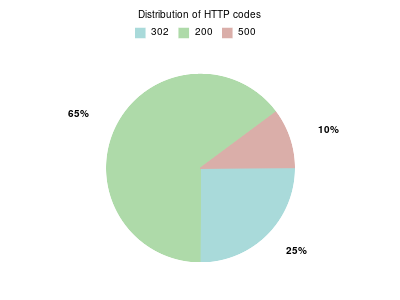

In [35]:
require 'gruff'
g = Gruff::Pie.new(400)
g.title = 'Distribution of HTTP codes'
g.marker_font_size = 20.0
g.legend_font_size = 20.0
g.title_font_size = 20.0
g.bold_title = false
g.theme_pastel
occurences_http_response_code.each do |key,val|
  g.data key, val
end
g.write()

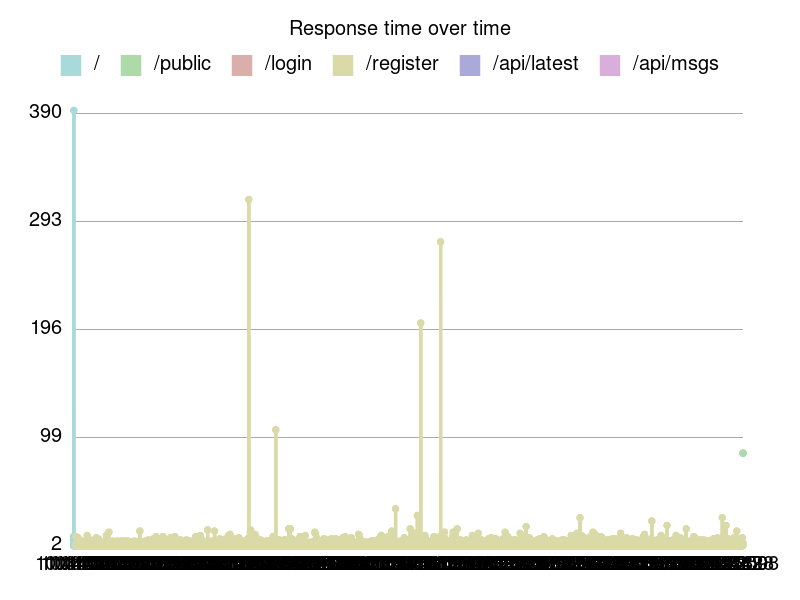

In [36]:
require 'time'

reduced_list = unfiltered_requests.filter { |e| e[:index] % 80 == 0 }

gl = Gruff::Line.new(800)
gl.title = 'Response time over time'
gl.marker_font_size = 20.0
gl.legend_font_size = 20.0
gl.title_font_size = 20.0
gl.dot_radius = 2
gl.line_width = 3
gl.bold_title = false
gl.theme_pastel
labels = Hash.new()
reduced_list.map do |h|
  labels[h[:index]] = Time.parse(h[:time]).strftime("%H:%M:%S")
end
gl.labels = labels
http_request_path_requests.each do |path|
  gl.data(path.to_sym, reduced_list.map { |h|
    if h[:http_request_path] == path then h[:http_response_time].to_i end
  })
end
gl.write()

In [ ]:
# Format for goaccess
formatted_requests = []
filename = "format__#{path}"
requests.each_with_index do |request, index|
  File.open(filename, 'a') { |f|
    ps = request.gsub('"', '').split("\s")
    f_time = DateTime.parse(ps[0]).strftime("%d/%b/%Y:%H:%M:%S %z")
    f_request = "\"#{ps[1]} #{ps[2]} HTTP/1.1\""
    f_code = ps[3]
    f_dur = ps[4].to_f / 1000
    f_line = "#{ip} - - [#{f_time}] #{f_request} #{f_code} - #{f_dur}"
    f.puts f_line
  }
end
""